In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy import units as u
from astropy.io import ascii
from astroquery.xmatch import XMatch
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic, Angle
from astropy.time import Time
from tqdm import tqdm
from scipy.stats import norm
import scipy.stats

In [2]:
pi = np.pi
sin = np.sin
cos = np.cos
log10 = np.log10
sqrt = np.sqrt

c=2.99792458*(10**8)
G=6.67428*(10**(-11))
s_mass=G*(1.98892*10**(30))/(c**3)

In [3]:
files = glob.glob('../IPTA_DR1/*/*.par')

In [64]:
def hist_weight(lst):
    return np.ones_like(lst)/len(lst)

def auto_bin(bin_size, min_edge, max_edge):
    #bin_size = 0.05; min_edge = -3.5; max_edge = -1
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)
    return bin_list

def ang_dist(alpha1, alpha2, delta1, delta2):
    """
    RA (alpha) and DEC (delta) are both in radians.
    returns angular distance in arcseconds.
    """
    alpha1 = alpha1*pi/180
    alpha2 = alpha2*pi/180
    delta1 = delta1*pi/180
    delta2 = delta2*pi/180

    arg = sin(delta1)*sin(delta2)+cos(delta1)*cos(delta2)*cos(alpha1-alpha2)
    theta = np.arccos(arg)*180/pi*3600
    est = np.sqrt(2*(1-arg))
    return theta

# plotting preamble

fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 2,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.0,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        #'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

In [5]:
ang_dist(60, 60.005, 10,10.001)

18.088373065939425

In [6]:
RAs = []
DECs = []
Names = []
pmra = []
pmra_err = []
pmdec = []
pmdec_err = []
pepoch = []
posepoch = []
dmepoch = []
dm = []
coords = []

In [7]:
for file in files:
    d = {}
    with open(file) as f:
        for line in f:
            key = line.split()[0]
            value = line.split()[1]
            d[key] = value
            if key in ['RAJ', 'DECJ', 'PMRA', 'PMDEC', 'PX']:
                try:
                    err = line.split()[3]
                    d[key+'_ERR'] = err
                except:
                    print("this file is missing uncertainties \
on {0}: {1}".format(key, file))
                    d[key+'_ERR'] = 0.0
    
    try:
        ra = Angle(d['RAJ'], u.hourangle).to(u.deg)
        dec = Angle(d['DECJ'], u.degree)
        coord = SkyCoord(ra=ra, dec=dec, frame='icrs',
                         pm_ra_cosdec = float(d['PMRA'])*u.mas/u.yr,
                         pm_dec=float(d['PMDEC'])*u.mas/u.yr,
                         obstime=Time(float(d['POSEPOCH']), format='mjd'),
                         distance=1. * u.kpc) # HACK
        coords.append(coord)
        RAs.append(ra.value)
        DECs.append(dec.value)
        Names.append(d['PSRJ'])
        pmra.append(coord.pm_ra_cosdec.value)
        pmra_err.append(float(d['PMRA_ERR']))
        pmdec.append(coord.pm_dec.value)
        pmdec_err.append(float(d['PMDEC_ERR']))
        pepoch.append(d['PEPOCH'])
        posepoch.append(d['POSEPOCH'])
        dmepoch.append(d['DMEPOCH'])
        dm.append(d['DM'])
        
    except KeyError:
        lon = float(d['ELONG'])*u.deg
        lat = float(d['ELAT'])*u.deg
        coord = SkyCoord(l=lon, b=lat, frame='galactic',
                             pm_l_cosb = float(d['PMELONG'])*u.mas/u.yr, 
                             pm_b=float(d['PMELAT'])*u.mas/u.yr,
                             obstime=Time(float(d['POSEPOCH']), format='mjd'),
                             distance=1. * u.kpc) # HACKITY HACK HACK
        icrscoord = coord.transform_to(ICRS)
        coords.append(icrscoord)
        print("this object has galactic coords: {0}".format(d['PSRJ']))
        RAs.append(icrscoord.ra.to(u.deg).value)
        DECs.append(icrscoord.dec.to(u.deg).value)
        Names.append(d['PSRJ'])
        pmra.append(icrscoord.pm_ra_cosdec.value)
        pmra_err.append(0.0) # TEMPORARY HACK
        pmdec.append(icrscoord.pm_dec.value)
        pmdec_err.append(0.0) # TEMPORARY HACK
        pepoch.append(d['PEPOCH'])
        posepoch.append(d['POSEPOCH'])
        dmepoch.append(d['DMEPOCH'])
        dm.append(d['DM']) 

this file is missing uncertainties on RAJ: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on DECJ: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PMRA: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PMDEC: ../IPTA_DR1/J0437-4715/J0437-4715.par
this file is missing uncertainties on PX: ../IPTA_DR1/J0437-4715/J0437-4715.par
this object has galactic coords: J1022+1001
this file is missing uncertainties on RAJ: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on DECJ: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PMRA: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PMDEC: ../IPTA_DR1/J1643-1224/J1643-1224.par
this file is missing uncertainties on PX: ../IPTA_DR1/J1643-1224/J1643-1224.par


In [8]:
Names

['J0030+0451',
 'J0034-0534',
 'J0218+4232',
 'J0437-4715',
 'J0610-2100',
 'J0613-0200',
 'J0621+1002',
 'J0711-6830',
 'J0751+1807',
 'J0900-3144',
 'J1012+5307',
 'J1022+1001',
 'J1024-0719',
 'J1045-4509',
 'J1455-3330',
 'J1600-3053',
 'J1603-7202',
 'J1640+2224',
 'J1643-1224',
 'J1713+0747',
 'J1721-2457',
 'J1730-2304',
 'J1732-5049',
 'J1738+0333',
 'J1744-1134',
 'J1751-2857',
 'J1801-1417',
 'J1802-2124',
 'J1804-2717',
 'J1824-2452A',
 'J1843-1113',
 'J1853+1303',
 'J1857+0943',
 'J1909-3744',
 'J1910+1256',
 'J1911+1347',
 'J1911-1114',
 'J1918-0642',
 'J1939+2134',
 'J1955+2908',
 'J2010-1323',
 'J2019+2425',
 'J2033+1734',
 'J2124-3358',
 'J2129-5721',
 'J2145-0750',
 'J2229+2643',
 'J2317+1439',
 'J2322+2057']

In [9]:
### J1804-2717

In [10]:
ind = np.where(np.array(Names) == 'J1804-2717')[0][0]

In [11]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [12]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (271.08805457, -27.29203619, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (2.45016982, -23.22141798)>

In [13]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=271.0877923 * u.degree, 
                             dec=-27.29173662* u.degree, frame='icrs',
                         pm_ra_cosdec =  0.499853246*u.mas/u.yr,
                         pm_dec= -8.587357973 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.242608527
gaia_dec_err = 0.220162839
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (271.0877923, -27.29173662, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (0.49985325, -8.58735797)>

In [14]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

1.4778438817410968

In [15]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 500/500 [01:02<00:00,  7.97it/s]


(array([  4.,  16.,  40.,  84., 104., 120.,  81.,  37.,  11.,   3.]),
 array([271.08805694, 271.08805732, 271.0880577 , 271.08805808,
        271.08805846, 271.08805884, 271.08805923, 271.08805961,
        271.08805999, 271.08806037, 271.08806075]),
 <a list of 10 Patch objects>)

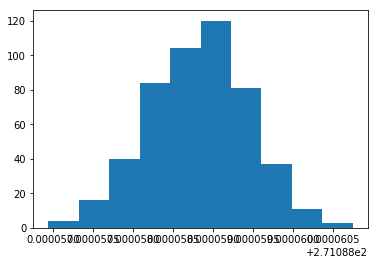

In [16]:
plt.hist(ipta_ras)

In [17]:
bin_list = auto_bin(np.std(gaia_ras)/5,np.min(gaia_ras)-np.std(gaia_ras),np.max(gaia_ras)+np.std(gaia_ras))
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


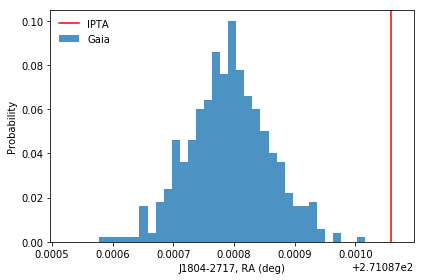

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(gaia_ras), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA") #3.7 sigma fit
#y = mlab.normpdf(bin_list, mu, sigma)
#plt.plot(bin_list, normed, 'r--', linewidth=2, label=r"Gaussian Fit")
plt.xlabel("J1804-2717, RA (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1804_RA_IPTA-GAIA-final.pdf")

In [19]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [20]:
diff

-3.943573397239853

In [21]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs),np.max(gaia_decs)+np.std(gaia_decs))
weights = hist_weight(gaia_decs)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


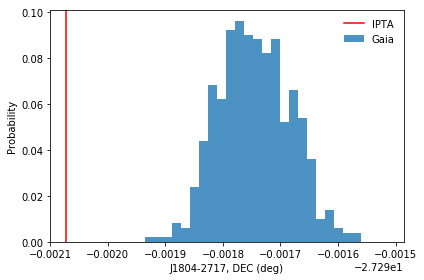

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #3 sigma away
plt.xlabel("J1804-2717, DEC (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1804_DEC_IPTA-GAIA-final.pdf")

In [8]:
### J1744-1134

In [12]:
ind = np.where(np.array(Names) == 'J1744-1134')[0][0]

In [13]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [14]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (266.12253142, -11.58185949, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (18.80023081, -9.40161871)>

In [15]:
ipta_posepoch

'55000'

In [16]:
55000-57023

-2023

In [17]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=266.1224646 * u.degree, 
                             dec=-11.58135898 * u.degree, frame='icrs',
                         pm_ra_cosdec =  -6.201087609*u.mas/u.yr,
                         pm_dec= -6.579072104 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 1.350768964
gaia_dec_err = 0.623526292
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (266.1224646, -11.58135898, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-6.20108761, -6.5790721)>

In [18]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

1.8848072167342882

In [14]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 500/500 [01:07<00:00,  7.39it/s]


In [23]:
bin_list = auto_bin(np.std(seps)/4,np.min(seps)-np.std(seps),np.max(seps)+np.std(seps))
weights = hist_weight(seps)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [24]:
# sample angles drawn from IPTA RA and DEC, compare to Gaia

In [25]:
ang_dist(alpha1, alpha2, delta1, delta2)

NameError: name 'alpha1' is not defined

In [26]:
np.random.choice(ipta_ras)

271.0880576814039

In [27]:
tmpAngles = []
for j in range(5000):
    tmpAngles.append(ang_dist(np.random.choice(ipta_ras), np.random.choice(gaia_ras), 
                              np.random.choice(ipta_decs), np.random.choice(gaia_decs)))

In [28]:
(muG, sigmaG) = norm.fit(tmpAngles)


In [29]:
(muG, sigmaG)

(1.4841693304637211, 0.2182013856347219)

In [ ]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [34]:
(muS, sigmaS) = norm.fit(seps)



In [35]:
(muS, sigmaS)

(2.3276770207470094, 0.6823772470442181)

In [40]:
diff = (muS-muG)/sigmaG

In [41]:
diff

0.003966366411505246

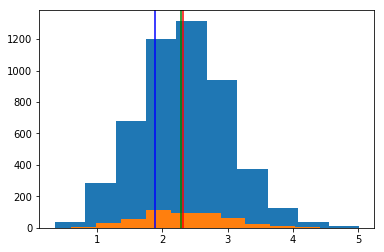

In [46]:
plt.hist(tmpAngles)
plt.hist(seps)
plt.axvline(np.median(tmpAngles), color='red', label = "random draws") #0.3 sigma fit
plt.axvline(np.median(seps), color='green', label = "seps") #0.3 sigma fit
plt.axvline(gaia_ipta_sep, color='blue', label = "actual") #0.3 sigma fit




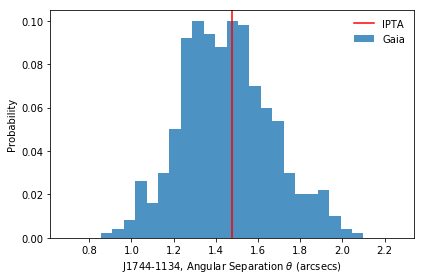

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(seps), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(gaia_ipta_sep), color='red', label = "IPTA")
plt.xlabel(r"J1744-1134, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("1744_thetas.pdf")

In [32]:
gaia_ras = np.array(gaia_ras) - 266.12
ipta_ras = np.array(ipta_ras) - 266.12

In [33]:
bin_list = auto_bin(np.std(gaia_ras)/5,np.min(gaia_ras)-np.std(gaia_ras),np.max(gaia_ras)+np.std(gaia_ras))
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


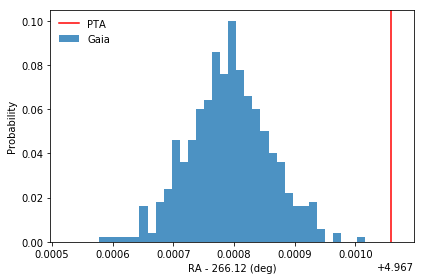

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(gaia_ras), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "PTA") #0.3 sigma fit
#y = mlab.normpdf(bin_list, mu, sigma)
#plt.plot(bin_list, normed, 'r--', linewidth=2, label=r"Gaussian Fit")
plt.xlabel("RA - 266.12 (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1744_RA_IPTA-GAIA-final.pdf")

In [39]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [40]:
2.6612e2

266.12

In [41]:
diff

-3.943573396337823

In [42]:
gaia_decs = np.array(gaia_decs)+ 11.58
ipta_decs = np.array(ipta_decs)+ 11.58



In [43]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs),np.max(gaia_decs)+np.std(gaia_decs))
weights = hist_weight(gaia_decs)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


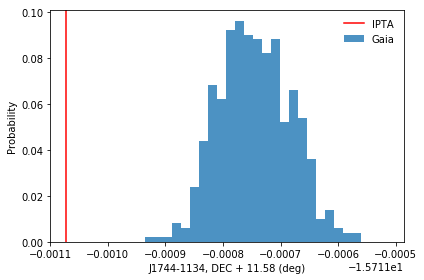

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #3 sigma away
plt.xlabel("J1744-1134, DEC + 11.58 (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1744_DEC_IPTA-GAIA-final.pdf")

In [ ]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma

In [ ]:
diff

### a bad case: J1910+1256

In [ ]:
ind = np.where(np.array(Names) == 'J1910+1256')[0][0]

In [ ]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [ ]:
ipta_coord = coords[ind]
ipta_coord

In [ ]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=287.5407215 * u.degree, 
                             dec=12.94037301 * u.degree, frame='icrs',
                         pm_ra_cosdec = -0.672057539 *u.mas/u.yr,
                         pm_dec= -5.449112763 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.576369178
gaia_dec_err = 0.623526292
gaia_match_coord

In [ ]:
# My angular separation calc for 1910

mySep = ang_dist(287.54042259, 287.5407215, 12.9404131, 12.94037301)


In [ ]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

In [ ]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

In [ ]:
gaia_ras = np.array(gaia_ras)+2*287.54
#ipta_ras = np.array(ipta_ras)-287.54



In [ ]:
bin_list = auto_bin(np.std(gaia_ras)/5,np.min(gaia_ras)-np.std(gaia_ras),np.max(gaia_ras)+np.std(gaia_ras))
weights = hist_weight(gaia_ras)

In [ ]:
np.std(gaia_ras)

In [ ]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [ ]:
(mu, sigma)

In [ ]:
diff

In [ ]:
# add a 'best fit' line
y = norm.fit(gaia_ras)

y = scipy.stats.norm.pdf(bin_list, mu, sigma)

l = plt.plot(bin_list, y, 'r--', linewidth=2)

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [ ]:
normed = []
for xx in range(len(bin_list)):
    normed.append(gaussian(bin_list[xx], mu, sigma))

In [ ]:
datos = gaia_ras
(mu, sigma) = norm.fit(datos)

# the histogram of the data
n, bins, patches = plt.hist(datos, 20, normed=.12, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = scipy.stats.norm.pdf(bins, mu, sigma)

l = plt.plot(bins, y, 'r--', linewidth=2)
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA")



In [ ]:
ipta_ras = np.array(ipta_ras)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(gaia_ras), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA")
#y = mlab.normpdf(bin_list, mu, sigma)
#plt.plot(bin_list, normed, 'r--', linewidth=2, label=r"Gaussian Fit")
plt.xlabel("J1910+1256, RA - 287.54 (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("J1910_RA_IPTA-GAIA-final.pdf")

In [ ]:
2.8754e2

In [ ]:
sigmaRA

In [ ]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs),np.max(gaia_decs)+np.std(gaia_decs))
weights = hist_weight(gaia_decs)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #0.2 sigma
plt.xlabel("J1910+1256, DEC (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1012_RA_IPTA-GAIA-final.pdf")

In [ ]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma

In [ ]:
diff

In [ ]:
bin_list = auto_bin(np.std(seps)/3,np.min(seps)-np.std(seps),np.max(seps)+np.std(seps))
weights = hist_weight(seps)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(seps), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(gaia_ipta_sep), color='red', label = "IPTA")
plt.xlabel(r"J1910+1256, Angular Separation $\theta$ (arcsecs)") #0.35 sigma
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("1910_thetas.pdf")

In [ ]:
(mu, sigma) = norm.fit(seps)
diff = (mu-np.median(gaia_ipta_sep))/sigma

In [ ]:
diff

In [ ]:
bin_listIPTA = auto_bin(np.std(gaia_ipta_sep)/3,np.min(gaia_ipta_sep)
                        -np.std(gaia_ipta_sep),np.max(gaia_ipta_sep)+np.std(gaia_ipta_sep))
weightsIPTA = hist_weight(gaia_ipta_sep)

## a not-so-bad disagreement case: J1012+5307

In [45]:
ind = np.where(np.array(Names) == 'J1012+5307')[0][0]

In [46]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [47]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (153.13932304, 53.1173056, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (2.62371226, -25.45880892)>

In [48]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=153.1393303 * u.degree, 
                             dec=53.11726303 * u.degree, frame='icrs',
                         pm_ra_cosdec = 2.976959985 *u.mas/u.yr,
                         pm_dec= -26.94384758 *u.mas/u.yr,
                         obstime= gaia_time,
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.241174616
gaia_dec_err = 0.302546482
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (153.1393303, 53.11726303, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (2.97695999, -26.94384758)>

In [49]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.012298049411488533

In [67]:
N = 1000
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 1000/1000 [01:40<00:00,  9.91it/s]


In [68]:
bin_list = auto_bin(np.std(seps)/4,np.min(seps)-np.std(seps),np.max(seps)+np.std(seps))
weights = hist_weight(seps)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


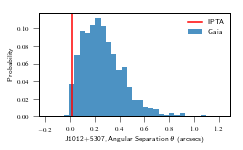

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(seps), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(gaia_ipta_sep), color='red', label = "IPTA")
plt.xlabel(r"J1012+5307, Angular Separation $\theta$ (arcsecs)") #1.6 sigma
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("1012_thetas.pdf")

In [70]:
(mu, sigma) = norm.fit(seps)
diff = (mu-np.median(gaia_ipta_sep))/sigma

In [71]:
diff

1.6380910987664827

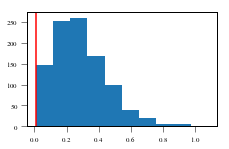

In [72]:
plt.hist(seps)
plt.axvline(gaia_ipta_sep, c='red')

In [73]:
gaia_ras = np.array(gaia_ras) -1.53139e2 #for better plotting

In [74]:
bin_list = auto_bin(np.std(gaia_ras)/4,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [75]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [76]:
mu

0.00033083878700057313

In [77]:
diff

-2286055.5213250276

In [78]:
ipta_ras = np.array(ipta_ras) -153.139

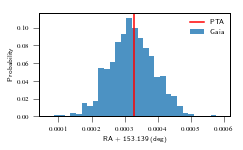

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(gaia_ras), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "PTA")
#y = mlab.normpdf(bin_list, mu, sigma)
#plt.plot(bin_list, normed, 'r--', linewidth=2, label=r"Gaussian Fit") # this is 0.04 sigma from mean
plt.xlabel("RA + 153.139 (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1012_RA_IPTA-GAIA.pdf")

In [ ]:
gaia_decs=np.array(gaia_decs) -53.117

In [ ]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)

In [ ]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma

In [ ]:
ipta_decs = np.array(ipta_decs) - 53.117

In [ ]:
diff

In [ ]:
ipta_decs = np.array(ipta_decs) - 53.117

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(np.array(gaia_decs), bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA")
#y = mlab.normpdf(bin_list, mu, sigma)
#plt.plot(bin_list, normed, 'r--', linewidth=2, label=r"Gaussian Fit") # this is 0.04 sigma from mean
plt.xlabel("J1012+5307, DEC + 53.117 (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1012_DEC_IPTA-GAIA.pdf")

In [ ]:
5.3117e1


## Best pulasr, J0437-4715


In [19]:
ind = np.where(np.array(Names) == 'J0437-4715')[0][0]

In [20]:
ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

In [21]:
ipta_pmra_err = 0.052 #Deller et al. 2008, Table 1
ipta_pmdec_err = 0.086 #Deller et al. 2008
ipta_posepoch = posepoch[ind]


In [22]:
ipta_posepoch

'54500'

In [28]:
arcSec2Deg = 0.000277778

In [29]:
yrMotion = abs(54500-57023)/365

In [52]:
tmpRA = 69.31623406 + 121.43993282*1e-3*yrMotion*arcSec2Deg * cos(-47.25253075*pi/180)*180/pi

In [53]:
GaiaPTA_diff = tmpRA - 69.31657761960786


In [54]:
GaiaPTA_diff

-0.00011038365990145849

In [57]:
cos(-47.25253075*pi/180)*180/pi

0.6787683099042595

In [58]:
-47.25253075*pi/180

-0.8247122414873655

In [43]:
121.43993282*1e-3*yrMotion*arcSec2Deg*cos(-47.25253075*pi/180)*180/pi


0.009068343060552427

In [37]:
GaiaDec = -47.25267778

In [33]:
GaiaRA = 69.31660276

In [34]:
tmpRA-GaiaRA

-0.000599949251878229

In [35]:
tmpDec = -47.25253075-71.47620158*1e-3*yrMotion*arcSec2Deg

In [38]:
tmpDec - GaiaDec

9.789055667397406e-06

In [53]:
ipta_coord = coords[ind]
ipta_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (69.31623406, -47.25253075, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (121.43993282, -71.47620158)>

In [54]:
gaia_time = Time(57023., format='mjd') # CHECK THAT THIS IS REALLY 2015.5 IN MJD
gaia_match_coord =  SkyCoord(ra=69.31660276 * u.degree, 
                             dec=-47.25267778 * u.degree, frame='icrs',
                         pm_ra_cosdec = 122.8637296 *u.mas/u.yr,
                         pm_dec= -71.16597382 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.582326756
gaia_dec_err = 0.738504992
gaia_match_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (69.31660276, -47.25267778, 1.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (122.8637296, -71.16597382)>

In [55]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

0.07154597070179823

In [ ]:
0.071544965

In [84]:
ang_dist(tmpRA, 69.31660276,tmpDec , -47.25267778)

0.33492207114758443

In [ ]:
# WORK BACKWARDS FROM THETA AND TRY TO DERIVE A CONTRADICTION

In [77]:
N = 1
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    print(ipta_ras)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

[69.31657761960786]


In [ ]:
bin_list = auto_bin(.05,-0.01,1)
weights = hist_weight(seps)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J0437-4715, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J0437_Theta_IPTA-GAIA.pdf")



In [ ]:
ipta_ras = np.array(ipta_ras) - 69.31
gaia_ras = np.array(gaia_ras) - 69.31

In [ ]:
bin_list = auto_bin(np.std(gaia_ras)/5,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

In [ ]:
max(gaia_ras)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA") #0.13 sigma
plt.xlabel("J0437-4715, RA - 69.31(deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J0437_RA_IPTA-GAIA.pdf")

In [ ]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [ ]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)

In [ ]:
ipta_decs = np.array(ipta_decs) + 47.25
gaia_decs = np.array(gaia_decs) + 47.25

In [ ]:
# DEC plot for J0437
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
#plt.hist(ipta_decs, bin_list2, weights=weights2, alpha = 0.8, align='left', color = 'C1', label = "IPTA")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA")
#plt.hist(ipta_decs)
##ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("J0437-4715, DEC + 47.25(deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("J0437_DEC_IPTA-GAIA.pdf")

In [ ]:
4.725e1

In [ ]:
ipta_decs + 47.25

## Pulsar J1024-0719

In [ ]:
ind = np.where(np.array(Names) == 'J1024-0719')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

In [ ]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=156.1610927 * u.degree, 
                             dec=-7.322165289 * u.degree, frame='icrs',
                         pm_ra_cosdec = -35.51929892*u.mas/u.yr,
                         pm_dec= -47.93231066 *u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.42985265
gaia_dec_err = 0.392656637
gaia_match_coord

In [ ]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

In [ ]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

In [ ]:
bin_list = auto_bin(.08,0.0,1.8)
weights = hist_weight(seps)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J1024-0719, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("J1024_Theta_IPTA-GAIA.pdf")

In [ ]:
gaia_ras = np.array(gaia_ras) - 1.5616e2

In [ ]:
ipta_ras = np.array(ipta_ras) - 1.5616e2

In [ ]:
bin_list = auto_bin(np.std(gaia_ras)/4,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

In [ ]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [ ]:
1.5616e2

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA") #0.06 sigma, great fit!
plt.xlabel("J1024-0719, RA + 156.16 (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1024_RA_IPTA-GAIA.pdf")

In [ ]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)


In [ ]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma



In [ ]:
diff

In [ ]:
# DEC plot for J1024
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #0.2 sigma away
#ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("J1024-0719, DEC (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1024_DEC_IPTA-GAIA.pdf")

## not so great pulsar J1732-5049

In [ ]:
ind = np.where(np.array(Names) == 'J1732-5049')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

In [ ]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=263.200006 * u.degree, 
                             dec=-50.8166163 * u.degree, frame='icrs',
                         pm_ra_cosdec = -0.031849016*u.mas/u.yr,
                         pm_dec= -10.483062*u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 2.168898313
gaia_dec_err = 2.010098257
gaia_match_coord

In [ ]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

In [ ]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

In [ ]:
bin_list = auto_bin(.5,0.0,8.0)
weights = hist_weight(seps)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J1732-5049, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1732_Theta_IPTA-GAIA.pdf")

In [ ]:
ipta_ras = np.array(ipta_ras)-263.2

In [ ]:
gaia_ras = np.array(gaia_ras)-263.2

In [ ]:
bin_list = auto_bin(np.std(gaia_ras)/4,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

In [ ]:
2.632e2

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA") #1.57 sigma
plt.xlabel("J1732, RA - 263.2 (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1732_RA_IPTA-GAIA.pdf")



In [ ]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [ ]:
mu

In [ ]:
sigma

In [ ]:
diff

In [ ]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)



In [ ]:
gaia_decs = np.array(gaia_decs)- 50.81

In [ ]:
ipta_decs = np.array(ipta_decs)+ 50.81

In [ ]:
# DEC plot for J1024
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #0.26 sigma away
#ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("J1732 + 50.81, DEC (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1732_DEC_IPTA-GAIA.pdf")

In [ ]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma

In [ ]:
diff

## Pulsar J1955+2908

In [ ]:
ind = np.where(np.array(Names) == 'J1955+2908')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

In [ ]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=298.8661015 * u.degree, 
                             dec=29.14538275 * u.degree, frame='icrs',
                         pm_ra_cosdec = -3.092116051*u.mas/u.yr,
                         pm_dec= -7.962991888*u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.125519342
gaia_dec_err = 0.165511548
gaia_match_coord

In [ ]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

In [ ]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

In [ ]:
bin_list = auto_bin(.05,0.0,0.8)
weights = hist_weight(seps)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(seps, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(gaia_ipta_sep, color='red', label = "IPTA")
plt.xlabel(r"J1955+2908, Angular Separation $\theta$ (arcsecs)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1955_Theta_IPTA-GAIA.pdf")

In [ ]:
ipta_ras = np.array(ipta_ras) - 298.85

In [ ]:
gaia_ras = np.array(gaia_ras) - 298.85

In [ ]:
bin_list = auto_bin(np.std(gaia_ras)/4,np.min(gaia_ras)-np.std(gaia_ras)/2,np.max(gaia_ras)+np.std(gaia_ras)/2)
weights = hist_weight(gaia_ras)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(gaia_ras, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA") #1.3 sigma
plt.xlabel("J1955+2908, RA - 298.85 (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1955_RA_IPTA-GAIA.pdf")

In [ ]:
(mu, sigma) = norm.fit(gaia_ras)
diff = (mu-np.median(ipta_ras))/sigma

In [ ]:
diff

In [ ]:
gaia_decs = np.array(gaia_decs) - 29.145

In [ ]:
ipta_decs = np.array(ipta_decs) - 29.145

In [ ]:
max(gaia_decs)

In [ ]:
bin_list = auto_bin(np.std(gaia_decs)/4,np.min(gaia_decs)-np.std(gaia_decs)/2,np.max(gaia_decs)+np.std(gaia_decs)/2)
weights = hist_weight(gaia_decs)

In [ ]:
# DEC plot for J1732
plt.hist(gaia_decs, bin_list, weights=weights, alpha = 0.8, align='left', color = 'C0', label = "Gaia")
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA") #0.4 sigma
ax.set_xlim([np.min(ipta_decs),np.max(ipta_decs)])
plt.xlabel("J1955+2908, DEC - 29.145 (deg)")
plt.ylabel("Probability")
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig("J1955_DEC_IPTA-GAIA.pdf")

In [ ]:
(mu, sigma) = norm.fit(gaia_decs)
diff = (mu-np.median(ipta_decs))/sigma


In [ ]:
diff

# Potential new binary

In [ ]:
ind = np.where(np.array(Names) == 'J1843-1113')[0][0]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]

ipta_pmra_err = pmra_err[ind]
ipta_pmdec_err = pmdec_err[ind]
ipta_posepoch = posepoch[ind]


ipta_coord = coords[ind]
ipta_coord

In [ ]:
gaia_time = Time(57023., format='mjd')
gaia_match_coord =  SkyCoord(ra=280.9223272 * u.degree, 
                             dec= -11.22530736* u.degree, frame='icrs',
                         pm_ra_cosdec = -3.241264413*u.mas/u.yr,
                         pm_dec= -7.274383834*u.mas/u.yr,
                         obstime=Time(2015.5, format='decimalyear'),
                         distance=1. * u.kpc) # HACK
gaia_ra_err = 0.666668976
gaia_dec_err = 0.644355643
gaia_match_coord

In [ ]:
gaia_ipta_sep = ipta_coord.apply_space_motion(new_obstime=gaia_time).separation(gaia_match_coord).arcsec
gaia_ipta_sep

In [ ]:
N = 500
seps = []
ipta_ras = []
ipta_decs = []
gaia_ras = []
gaia_decs = []
for n in tqdm(range(N)):
    c1 = SkyCoord(ra=ipta_coord.ra,
                 dec=ipta_coord.dec, frame='icrs',
                 pm_ra_cosdec=np.random.normal(ipta_coord.pm_ra_cosdec.value, 
                                               ipta_pmra_err) * u.mas/u.yr,
                 pm_dec=np.random.normal(ipta_coord.pm_dec.value, 
                                               ipta_pmdec_err) * u.mas/u.yr,
                 obstime=ipta_coord.obstime,
                 distance=ipta_coord.distance)
    c2 = SkyCoord(ra=np.random.normal(gaia_match_coord.ra.arcsec, gaia_ra_err) * u.arcsec,
                 dec=np.random.normal(gaia_match_coord.dec.arcsec, gaia_dec_err) * u.arcsec, 
                 frame='icrs',
                 pm_ra_cosdec=gaia_match_coord.pm_ra_cosdec, 
                 pm_dec=gaia_match_coord.pm_dec, 
                 obstime=gaia_match_coord.obstime,
                 distance=gaia_match_coord.distance)
    ipta_ras.append(c1.apply_space_motion(new_obstime=gaia_time).ra.degree)
    ipta_decs.append(c1.apply_space_motion(new_obstime=gaia_time).dec.degree)
    gaia_ras.append(c2.ra.degree)
    gaia_decs.append(c2.dec.degree)
    sep = c1.apply_space_motion(new_obstime=gaia_time).separation(c2).arcsec
    seps.append(sep)

In [ ]:
plt.hist(seps)
plt.axvline(np.median(seps), color='red', label = "IPTA")

In [ ]:
plt.hist(gaia_ras)
plt.axvline(np.median(ipta_ras), color='red', label = "IPTA")

In [ ]:
plt.hist(gaia_decs)
plt.axvline(np.median(ipta_decs), color='red', label = "IPTA")

In [ ]:
import statsmodels.api as sm
import matplotlib.mlab as ml
from scipy.stats import norm




In [ ]:
bin_list = auto_bin(.1,0,3.5)
weights = hist_weight(seps)

(mu, sigma) = norm.fit(seps)
y = mlab.normpdf(bin_list, mu, sigma)
l = plt.plot(bin_list, y, 'r--', linewidth=2)
plt.axvline(np.median(seps), color='red', label = "IPTA")
plt.hist(seps, bin_list, weights = weights, edgecolor = 'black', alpha =0.8, align='left')
plt.ylabel("Probability")
plt.xlabel("binary separation")
plt.tight_layout()

In [ ]:
mu

In [ ]:
sigma

In [ ]:
plt.plot(bin_list, y, 'r--', linewidth=2)



In [ ]:
frac = [0.00027815, 0.00027772, 0.00027801, 0.00027789, 0.00027739, 0.00027773, 0.00027794]

In [ ]:
plt.hist(np.log10(frac))

In [ ]:
bin_list = auto_bin(1e-5,-3.5570, -3.5560)
weights = hist_weight(frac)

#(mu, sigma) = norm.fit(np.log10(frac))
#y = mlab.normpdf(bin_list, mu, sigma)
#l = plt.plot(bin_list, y, 'r--', linewidth=2)
#plt.axvline(np.median(seps), color='red', label = "IPTA")
plt.hist(np.log10(frac), bin_list, weights = weights, edgecolor = 'black', alpha =0.8, align='left')
plt.ylabel("Probability")
plt.xlabel("Gaia/IPTA")
plt.tight_layout()

In [ ]:
np.average(frac)

In [ ]:
np.mean(frac)

In [ ]:
normConst = np.average(frac)